# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.0
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load the IMFs of the observations

In [2]:
%%time

os.chdir(wrkdir + "/data/")
imfs_sst_ds = xr.open_dataset("imfs_sst.nc")
imfs_mld_ds = xr.open_dataset("imfs_mld.nc")
imfs_oxy200m_ds = xr.open_dataset("imfs_oxy200m.nc")
imfs_oxycline_ds = xr.open_dataset("imfs_oxycline.nc")
imfs_p50_critz_ds = xr.open_dataset("imfs_p50_critz.nc")
imfs_pO2_m_p50_z50_ds = xr.open_dataset("imfs_pO2_m_p50_z50.nc")
imfs_pO2_m_p50_z100_ds = xr.open_dataset("imfs_pO2_m_p50_z100.nc")
imfs_pO2_m_p50_z150_ds = xr.open_dataset("imfs_pO2_m_p50_z150.nc")
imfs_pO2_m_p50_z200_ds = xr.open_dataset("imfs_pO2_m_p50_z200.nc")
imfs_pO2_m_p50_z250_ds = xr.open_dataset("imfs_pO2_m_p50_z250.nc")
imfs_pO2_m_p50_z300_ds = xr.open_dataset("imfs_pO2_m_p50_z300.nc")
imfs_chl_ds = xr.open_dataset("imfs_chl.nc")

imfs_p50_critz_ds


CPU times: user 265 ms, sys: 170 ms, total: 435 ms
Wall time: 2.87 s


<xarray.Dataset> Size: 401MB
Dimensions:          (IMF: 3, time: 240, lat: 145, lon: 360)
Coordinates:
    depth            (time) float32 960B ...
  * time             (time) datetime64[ns] 2kB 2004-01-15 ... 2023-12-15
    month            (time) int64 2kB ...
  * IMF              (IMF) int64 24B 1 2 3
  * lat              (lat) float32 580B -64.5 -63.5 -62.5 ... 77.5 78.5 79.5
  * lon              (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    p50_critz_imfs   (IMF, time, lat, lon) float64 301MB ...
    p50_critz_anom   (time, lat, lon) float32 50MB ...
    p50_critz_detr   (time, lat, lon) float32 50MB ...
    p50_critz_trend  (lat, lon) float32 209kB ...

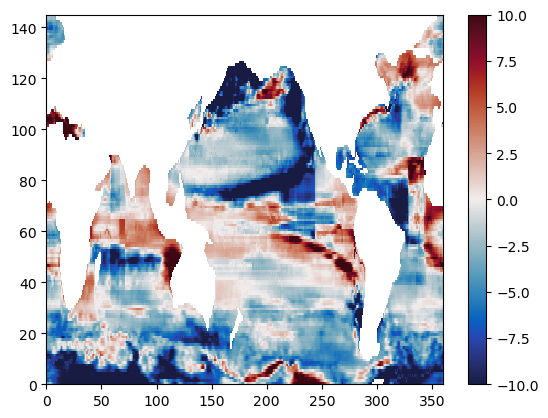

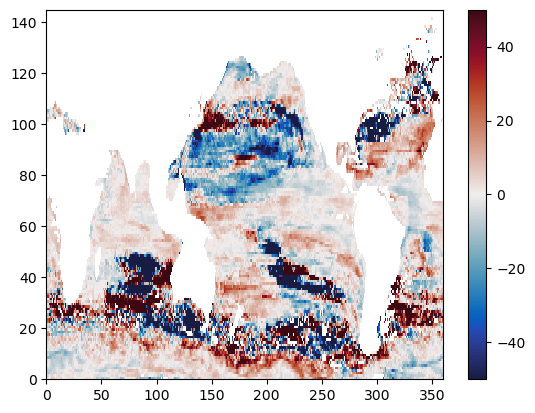

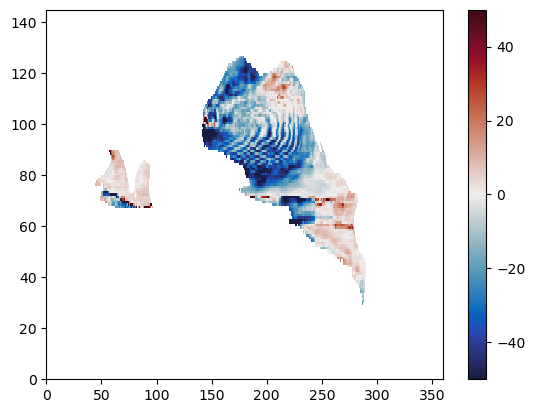

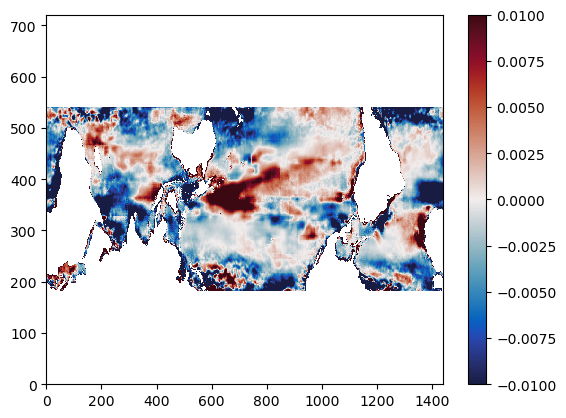

In [3]:
plt.figure()
plt.pcolormesh(imfs_oxy200m_ds['oxy200m_trend'], cmap=cmo.balance, vmin=-10, vmax=10)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_oxycline_ds['oxycline_trend'], cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_p50_critz_ds['p50_critz_trend'], cmap=cmo.balance, vmin=-50, vmax=50)
plt.colorbar()

plt.figure()
plt.pcolormesh(imfs_chl_ds['chl_trend'], cmap=cmo.balance, vmin=-1e-2, vmax=1e-2)
plt.colorbar()

## Load ENSO and IPO indices

### Regular IPO index

In [4]:
dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


/jobfs/136968028.gadi-pbs/ipykernel_241816/3220979946.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


/jobfs/136968028.gadi-pbs/ipykernel_241816/2646364633.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


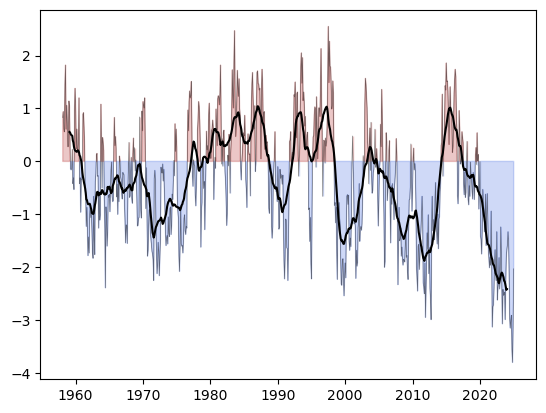

In [5]:
'''
https://www.ncei.noaa.gov/access/monitoring/pdo/
'''

dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")

ipo_index = pd.read_csv(wrkdir + "/data/IPO.txt", delimiter=',')
ipo_index[ipo_index == 99.99] = np.nan

ipo_subset = ipo_index[(ipo_index['Year']>1957) & (ipo_index['Year']<2025)]
ipo_subset.drop(columns='Year').values.flatten()
ipo = pd.DataFrame(
    {"time": dates,
     "index": ipo_subset.drop(columns='Year').values.flatten(),
    }
)

ipo['pos'] = ipo['index'][ipo['index']>0.0]
ipo['neg'] = ipo['index'][ipo['index']<0.0]
ipo['smooth'] = ipo['index'].rolling(window=25, center=True).mean()

plt.figure()
plt.plot(ipo['time'], ipo['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(ipo['time'], 0, ipo['pos'], color='firebrick', alpha=0.25)
plt.fill_between(ipo['time'], 0, ipo['neg'], color='royalblue', alpha=0.25)
plt.plot(ipo['time'], ipo['smooth'], 'k-', alpha=1.0)



### Tripolar IPO index

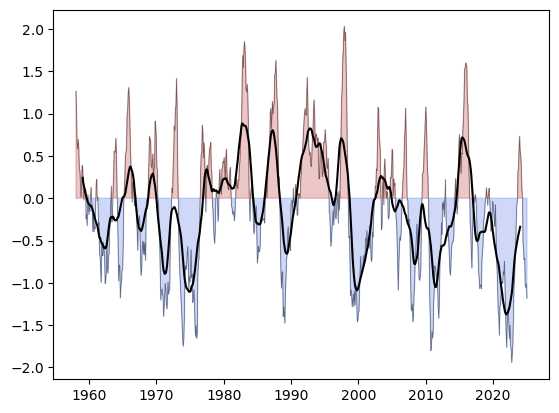

In [6]:

'''
https://psl.noaa.gov/data/timeseries/IPOTPI/
 (filitered from NOAA ERSST V5)
'''

tpi_index = pd.read_csv(wrkdir + "/data/Tripolar_IPO.txt", delimiter=',')
tpi_index[tpi_index == 99.99] = np.nan

tpi_subset = tpi_index[(tpi_index['Year']>1957) & (tpi_index['Year']<2025)]
tpi_subset.drop(columns='Year').values.flatten()
tpi = pd.DataFrame(
    {"time": dates,
     "index": tpi_subset.drop(columns='Year').values.flatten(),
    }
)

tpi['pos'] = tpi['index'][tpi['index']>0.0]
tpi['neg'] = tpi['index'][tpi['index']<0.0]
tpi['smooth'] = tpi['index'].rolling(window=25, center=True).mean()                   

plt.figure()
plt.plot(tpi['time'], tpi['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(tpi['time'], 0, tpi['pos'], color='firebrick', alpha=0.25)
plt.fill_between(tpi['time'], 0, tpi['neg'], color='royalblue', alpha=0.25)
plt.plot(tpi['time'], tpi['smooth'], 'k-', alpha=1.0)


### ENSO index

/jobfs/136968028.gadi-pbs/ipykernel_241816/2507760179.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  enso_index = pd.read_csv(wrkdir + "/data/ONI.txt", delimiter=', ')


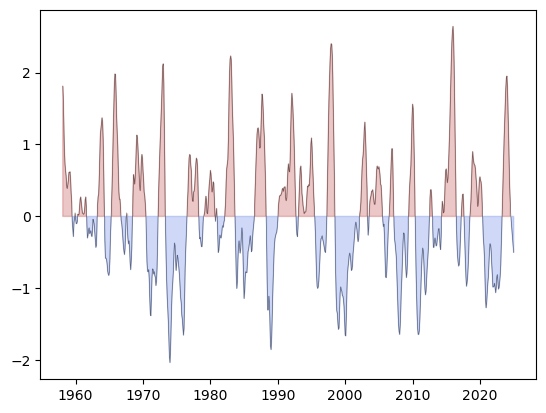

In [7]:
'''
https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
'''

enso_index = pd.read_csv(wrkdir + "/data/ONI.txt", delimiter=', ')
enso_subset = enso_index[(enso_index['YR']>1957) & (enso_index['YR']<2025)]
enso = pd.DataFrame(
    {"time": dates,
     "index": enso_subset.drop(columns=['SEAS','YR']).squeeze(),
    }
)

enso['pos'] = enso['index'][enso['index']>0.0]
enso['neg'] = enso['index'][enso['index']<0.0]

plt.figure()
plt.plot(enso['time'], enso['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(enso['time'], 0, enso['pos'], color='firebrick', alpha=0.25)
plt.fill_between(enso['time'], 0, enso['neg'], color='royalblue', alpha=0.25)


## Determine the frequency of ENSO and IPO

In [8]:
ipo

,time,index,pos,neg,smooth
0,1958-01-31,0.83,0.83,NaN,NaN
1,1958-02-28,0.94,0.94,NaN,NaN
2,1958-03-31,0.62,0.62,NaN,NaN
3,1958-04-30,0.56,0.56,NaN,NaN
4,1958-05-31,1.46,1.46,NaN,NaN
...,...,...,...,...,...
799,2024-08-31,-2.91,NaN,-2.91,NaN
800,2024-09-30,-3.56,NaN,-3.56,NaN
801,2024-10-31,-3.80,NaN,-3.80,NaN
802,2024-11-30,-3.13,NaN,-3.13,NaN


In [9]:
%%time

from scipy.signal import hilbert

years = np.arange(1958+0.5/12, 2024+11.51/12, 1/12)

analytic_signal = hilbert(enso['index'])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
enso_freq = np.mean(np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years)))
   
analytic_signal = hilbert(ipo['smooth'][12:791])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
ipo_freq = np.mean(np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years[12:791])))

print("ENSO period = %.2f years"%(1/enso_freq))
print("IPO period = %.2f years"%(1/ipo_freq))



ENSO period = 3.21 years
IPO period = 13.26 years
CPU times: user 2.77 ms, sys: 1.52 ms, total: 4.29 ms
Wall time: 3.55 ms


## Correlation analysis against ENSO and IPO indices

In [10]:
print(np.shape(imfs_sst_ds['sst_imfs']))
print(np.shape(imfs_mld_ds['mld_imfs']))
print(np.shape(imfs_oxy200m_ds['oxy200m_imfs']))
print(np.shape(imfs_oxycline_ds['oxycline_imfs']))
print(np.shape(imfs_p50_critz_ds['p50_critz_imfs']))
print(np.shape(imfs_pO2_m_p50_z50_ds['pO2_m_p50_z50_imfs']))
print(np.shape(imfs_pO2_m_p50_z100_ds['pO2_m_p50_z100_imfs']))
print(np.shape(imfs_pO2_m_p50_z150_ds['pO2_m_p50_z150_imfs']))
print(np.shape(imfs_pO2_m_p50_z200_ds['pO2_m_p50_z200_imfs']))
print(np.shape(imfs_pO2_m_p50_z250_ds['pO2_m_p50_z250_imfs']))
print(np.shape(imfs_pO2_m_p50_z300_ds['pO2_m_p50_z300_imfs']))
print(np.shape(imfs_chl_ds['chl_imfs']))


(3, 240, 173, 360)
(3, 240, 173, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 240, 145, 360)
(3, 276, 721, 1440)


In [11]:
%%time

enso_sst_ccoef = np.zeros((2,173,360))
ipo_sst_ccoef = np.zeros((2,173,360))

enso_mld_ccoef = np.zeros((2,173,360))
ipo_mld_ccoef = np.zeros((2,173,360))

enso_oxy200m_ccoef = np.zeros((2,145,360))
ipo_oxy200m_ccoef = np.zeros((2,145,360))

enso_oxycline_ccoef = np.zeros((2,145,360))
ipo_oxycline_ccoef = np.zeros((2,145,360))

enso_p50_critz_ccoef = np.zeros((2,145,360))
ipo_p50_critz_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z50_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z50_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z100_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z100_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z150_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z150_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z200_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z200_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z250_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z250_ccoef = np.zeros((2,145,360))

enso_pO2_m_p50_z300_ccoef = np.zeros((2,145,360))
ipo_pO2_m_p50_z300_ccoef = np.zeros((2,145,360))

enso_chl_ccoef = np.zeros((2,721,1440))
ipo_chl_ccoef = np.zeros((2,721,1440))


enso_sst_slope = np.zeros((5,173,360))
ipo_sst_slope = np.zeros((5,173,360))

enso_mld_slope = np.zeros((5,173,360))
ipo_mld_slope = np.zeros((5,173,360))

enso_oxy200m_slope = np.zeros((5,145,360))
ipo_oxy200m_slope = np.zeros((5,145,360))

enso_oxycline_slope = np.zeros((5,145,360))
ipo_oxycline_slope = np.zeros((5,145,360))

enso_p50_critz_slope = np.zeros((5,145,360))
ipo_p50_critz_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z50_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z50_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z100_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z100_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z150_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z150_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z200_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z200_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z250_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z250_slope = np.zeros((5,145,360))

enso_pO2_m_p50_z300_slope = np.zeros((5,145,360))
ipo_pO2_m_p50_z300_slope = np.zeros((5,145,360))

enso_chl_slope = np.zeros((5,721,1440))
ipo_chl_slope = np.zeros((5,721,1440))


sst_imfs = imfs_sst_ds['sst_imfs']
mld_imfs = imfs_mld_ds['mld_imfs']
oxy200m_imfs = imfs_oxy200m_ds['oxy200m_imfs']
oxycline_imfs = imfs_oxycline_ds['oxycline_imfs']
p50_critz_imfs = imfs_p50_critz_ds['p50_critz_imfs']
pO2_m_p50_z50_imfs = imfs_pO2_m_p50_z50_ds['pO2_m_p50_z50_imfs']
pO2_m_p50_z100_imfs = imfs_pO2_m_p50_z100_ds['pO2_m_p50_z100_imfs']
pO2_m_p50_z150_imfs = imfs_pO2_m_p50_z150_ds['pO2_m_p50_z150_imfs']
pO2_m_p50_z200_imfs = imfs_pO2_m_p50_z200_ds['pO2_m_p50_z200_imfs']
pO2_m_p50_z250_imfs = imfs_pO2_m_p50_z250_ds['pO2_m_p50_z250_imfs']
pO2_m_p50_z300_imfs = imfs_pO2_m_p50_z300_ds['pO2_m_p50_z300_imfs']
chl_imfs = imfs_chl_ds['chl_imfs']


CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 12.3 ms
Parser   : 187 ms


In [13]:
#sst_imfs.coords['time'].max()
#ipo[ipo['time'].dt.year > 2004][-13::]
#ipo[ipo['time'].dt.year > 2004]['time'][0:-12]
#sst_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31"))
chl_imfs.isel(lon=0, lat=0, IMF=0)
#enso[enso['time'].dt.year > 2003]['time'][0:-12]

<xarray.DataArray 'chl_imfs' (time: 276)> Size: 2kB
[276 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2001-01-31 2001-02-28 ... 2023-12-31
    month    (time) int64 2kB ...
    IMF      int64 8B 1
    lat      float64 8B 90.12
    lon      float64 8B 0.125

In [37]:
%%time

### Collect correlations and effects (slopes) of the ENSO and IPO with the variables we care about
for ix,lon in enumerate(sst_imfs.coords['lon'].values):
    if ix % 20 == 0:
        print(ix)
    for iy,lat in enumerate(sst_imfs.coords['lat'].values):
        data = sst_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_sst_ccoef[:,iy,ix] = sci.stats.pearsonr(sst_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2004]['index'])[:]
            ipo_sst_ccoef[:,iy,ix] = sci.stats.pearsonr(sst_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31")), ipo[ipo['time'].dt.year > 2004]['smooth'][0:-12])[:]
            enso_sst_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2004]['index'], sst_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_sst_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2004]['smooth'][0:-12], sst_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31")))[:]
        data = mld_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_mld_ccoef[:,iy,ix] = sci.stats.pearsonr(mld_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2004]['index'])[:]
            ipo_mld_ccoef[:,iy,ix] = sci.stats.pearsonr(mld_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31")), ipo[ipo['time'].dt.year > 2004]['smooth'][0:-12])[:]
            enso_mld_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2004]['index'], mld_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_mld_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2004]['smooth'][0:-12], mld_imfs.isel(IMF=2, lat=iy, lon=ix).sel(time=slice("2005-01-01","2023-12-31")))[:]



0



KeyboardInterrupt



In [ ]:
%%time

sst_corr_ds = xr.Dataset(
    {
        "sst_corr_enso": (["coef_pval", "lat", "lon"], enso_sst_ccoef),
        "sst_corr_ipo": (["coef_pval", "lat", "lon"], ipo_sst_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

mld_corr_ds = xr.Dataset(
    {
        "mld_corr_enso": (["coef_pval", "lat", "lon"], enso_mld_ccoef),
        "mld_corr_ipo": (["coef_pval", "lat", "lon"], ipo_mld_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

sst_effect_ds = xr.Dataset(
    {
        "sst_effect_enso": (["stats", "lat", "lon"], enso_sst_slope),
        "sst_effect_ipo": (["stats", "lat", "lon"], ipo_sst_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

mld_effect_ds = xr.Dataset(
    {
        "mld_effect_enso": (["stats", "lat", "lon"], enso_mld_slope),
        "mld_effect_ipo": (["stats", "lat", "lon"], ipo_mld_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": sst_imfs.coords['lat'].values,
        "lon": sst_imfs.coords['lon'].values,
    },
)

os.chdir(wrkdir + "/data")
os.remove("sst_corr_ENSO_IPO.nc")
os.remove("mld_corr_ENSO_IPO.nc")
os.remove("sst_effect_ENSO_IPO.nc")
os.remove("mld_effect_ENSO_IPO.nc")

sst_corr_ds.to_netcdf("sst_corr_ENSO_IPO.nc")
mld_corr_ds.to_netcdf("mld_corr_ENSO_IPO.nc")
sst_effect_ds.to_netcdf("sst_effect_ENSO_IPO.nc")
mld_effect_ds.to_netcdf("mld_effect_ENSO_IPO.nc")



In [38]:
%%time

for ix,lon in enumerate(oxy200m_imfs.coords['lon'].values):
    if ix % 20 == 0:
        print(ix)
    for iy,lat in enumerate(oxy200m_imfs.coords['lat'].values):
        data = oxy200m_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_oxy200m_ccoef[:,iy,ix] = sci.stats.pearsonr(oxy200m_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2003]['index'][0:-12])[:]
            ipo_oxy200m_ccoef[:,iy,ix] = sci.stats.pearsonr(oxy200m_imfs.isel(IMF=2, lat=iy, lon=ix), ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12])[:]
            enso_oxy200m_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2003]['index'][0:-12], oxy200m_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_oxy200m_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12], oxy200m_imfs.isel(IMF=2, lat=iy, lon=ix))[:]

for ix,lon in enumerate(oxy200m_imfs.coords['lon'].values):
    if ix % 20 == 0:
        print(ix)
    for iy,lat in enumerate(oxy200m_imfs.coords['lat'].values):
        data = oxycline_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_oxycline_ccoef[:,iy,ix] = sci.stats.pearsonr(oxycline_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2003]['index'][0:-12])[:]
            ipo_oxycline_ccoef[:,iy,ix] = sci.stats.pearsonr(oxycline_imfs.isel(IMF=2, lat=iy, lon=ix), ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12])[:]
            enso_oxycline_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2003]['index'][0:-12], oxycline_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_oxycline_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12], oxycline_imfs.isel(IMF=2, lat=iy, lon=ix))[:]

for ix,lon in enumerate(oxy200m_imfs.coords['lon'].values):
    if ix % 20 == 0:
        print(ix)
    for iy,lat in enumerate(oxy200m_imfs.coords['lat'].values):
        data = p50_critz_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_p50_critz_ccoef[:,iy,ix] = sci.stats.pearsonr(p50_critz_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2003]['index'][0:-12])[:]
            ipo_p50_critz_ccoef[:,iy,ix] = sci.stats.pearsonr(p50_critz_imfs.isel(IMF=2, lat=iy, lon=ix), ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12])[:]
            enso_p50_critz_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2003]['index'][0:-12], p50_critz_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_p50_critz_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2003]['smooth'][0:-12], p50_critz_imfs.isel(IMF=2, lat=iy, lon=ix))[:]
       


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
CPU times: user 11min 32s, sys: 22min 25s, total: 33min 58s
Wall time: 35min 24s


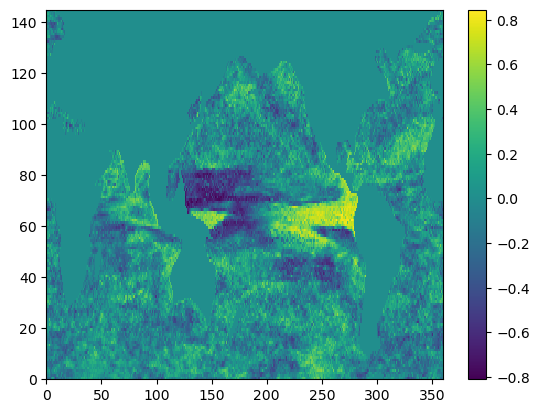

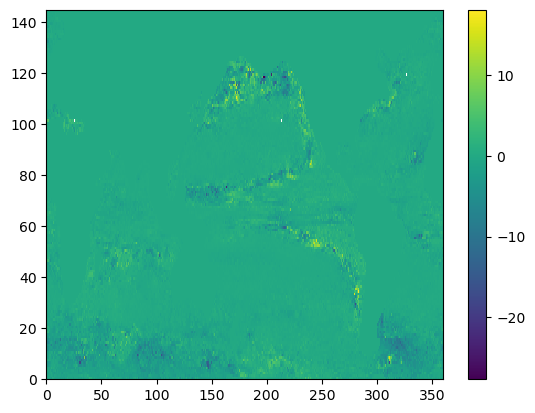

In [39]:
plt.figure()
plt.pcolormesh(enso_oxy200m_ccoef[0,:,:])
plt.colorbar()

plt.figure()
plt.pcolormesh(oxy200m_imfs.isel(IMF=1,time=0))
plt.colorbar()


In [40]:

oxy200m_corr_ds = xr.Dataset(
    {
        "oxy200m_corr_enso": (["coef_pval", "lat", "lon"], enso_oxy200m_ccoef),
        "oxy200m_corr_ipo": (["coef_pval", "lat", "lon"], ipo_oxy200m_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)

oxycline_corr_ds = xr.Dataset(
    {
        "oxycline_corr_enso": (["coef_pval", "lat", "lon"], enso_oxycline_ccoef),
        "oxycline_corr_ipo": (["coef_pval", "lat", "lon"], ipo_oxycline_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)

p50_critz_corr_ds = xr.Dataset(
    {
        "p50_critz_corr_enso": (["coef_pval", "lat", "lon"], enso_p50_critz_ccoef),
        "p50_critz_corr_ipo": (["coef_pval", "lat", "lon"], ipo_p50_critz_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)

oxy200m_effect_ds = xr.Dataset(
    {
        "oxy200m_effect_enso": (["stats", "lat", "lon"], enso_oxy200m_slope),
        "oxy200m_effect_ipo": (["stats", "lat", "lon"], ipo_oxy200m_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)

oxycline_effect_ds = xr.Dataset(
    {
        "oxycline_effect_enso": (["stats", "lat", "lon"], enso_oxycline_slope),
        "oxycline_effect_ipo": (["stats", "lat", "lon"], ipo_oxycline_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)

p50_critz_effect_ds = xr.Dataset(
    {
        "p50_critz_effect_enso": (["stats", "lat", "lon"], enso_p50_critz_slope),
        "p50_critz_effect_ipo": (["stats", "lat", "lon"], ipo_p50_critz_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": oxy200m_imfs.coords['lat'].values,
        "lon": oxy200m_imfs.coords['lon'].values,
    },
)


os.chdir(wrkdir + "/data")
os.remove("oxy200m_corr_ENSO_IPO.nc")
os.remove("oxycline_corr_ENSO_IPO.nc")
os.remove("p50_critz_corr_ENSO_IPO.nc")
os.remove("oxy200m_effect_ENSO_IPO.nc")
os.remove("oxycline_effect_ENSO_IPO.nc")
os.remove("p50_critz_effect_ENSO_IPO.nc")

oxy200m_corr_ds.to_netcdf("oxy200m_corr_ENSO_IPO.nc")
oxycline_corr_ds.to_netcdf("oxycline_corr_ENSO_IPO.nc")
p50_critz_corr_ds.to_netcdf("p50_critz_corr_ENSO_IPO.nc")
oxy200m_effect_ds.to_netcdf("oxy200m_effect_ENSO_IPO.nc")
oxycline_effect_ds.to_netcdf("oxycline_effect_ENSO_IPO.nc")
p50_critz_effect_ds.to_netcdf("p50_critz_effect_ENSO_IPO.nc")


In [14]:
chl_imfs.coords['lon']


<xarray.DataArray 'lon' (lon: 1440)> Size: 12kB
array([1.25000e-01, 3.75000e-01, 6.25000e-01, ..., 3.59375e+02, 3.59625e+02,
       3.59875e+02])
Coordinates:
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9

In [12]:
%%time

for ix,lon in enumerate(chl_imfs.coords['lon'].values):
    if ix % 40 == 0:
        print(ix)
    for iy,lat in enumerate(chl_imfs.coords['lat'].values):
        data = chl_imfs.isel(lon=ix, lat=iy)
        if data.notnull().all() and not (data == 0.0).all():
            enso_chl_ccoef[:,iy,ix] = sci.stats.pearsonr(chl_imfs.isel(IMF=1, lat=iy, lon=ix), enso[enso['time'].dt.year > 2000]['index'][0:-12])[:]
            ipo_chl_ccoef[:,iy,ix] = sci.stats.pearsonr(chl_imfs.isel(IMF=2, lat=iy, lon=ix), ipo[ipo['time'].dt.year > 2000]['smooth'][0:-12])[:]
            enso_chl_slope[:,iy,ix] = sci.stats.linregress(enso[enso['time'].dt.year > 2000]['index'][0:-12], chl_imfs.isel(IMF=1, lat=iy, lon=ix))[:]
            ipo_chl_slope[:,iy,ix] = sci.stats.linregress(ipo[ipo['time'].dt.year > 2000]['smooth'][0:-12], chl_imfs.isel(IMF=2, lat=iy, lon=ix))[:]


0
40
80
120
160
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880
920
960
1000
1040
1080
1120
1160
1200
1240
1280
1320
1360
1400
CPU times: user 1h 9min 28s, sys: 3h 43min 31s, total: 4h 53min
Wall time: 6h 48min 30s


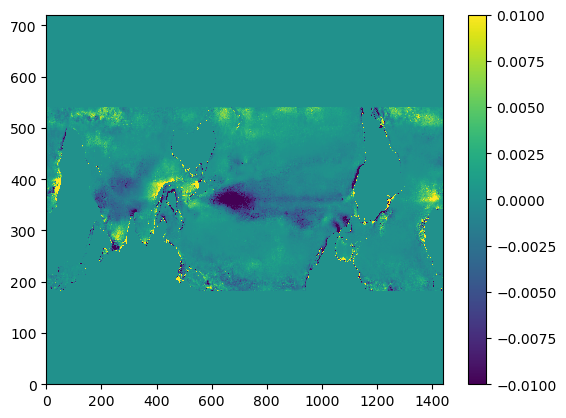

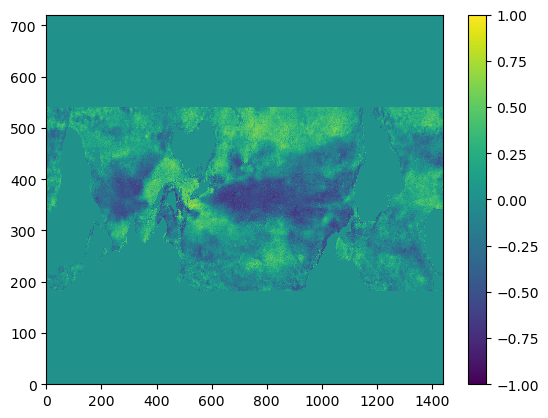

In [22]:
np.shape(ipo_chl_slope)
plt.figure()
plt.pcolormesh(enso_chl_slope[0,:,:], vmin=-0.01, vmax=0.01)
plt.colorbar()

plt.figure()
plt.pcolormesh(enso_chl_ccoef[0,:,:], vmin=-1, vmax=1)
plt.colorbar()



In [25]:
%%time

chl_corr_ds = xr.Dataset(
    {
        "chl_corr_enso": (["coef_pval", "lat", "lon"], enso_chl_ccoef),
        "chl_corr_ipo": (["coef_pval", "lat", "lon"], ipo_chl_ccoef),
    },
    coords={
        "coef_pval": np.arange(0,2,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)

chl_effect_ds = xr.Dataset(
    {
        "chl_effect_enso": (["stats", "lat", "lon"], enso_chl_slope),
        "chl_effect_ipo": (["stats", "lat", "lon"], ipo_chl_slope),
    },
    coords={
        "stats": np.arange(0,5,1),
        "lat": chl_imfs.coords['lat'].values,
        "lon": chl_imfs.coords['lon'].values,
    },
)



os.chdir(wrkdir + "/data")
os.remove("chl_corr_ENSO_IPO.nc")
os.remove("chl_effect_ENSO_IPO.nc")

chl_corr_ds.to_netcdf("chl_corr_ENSO_IPO.nc")
chl_effect_ds.to_netcdf("chl_effect_ENSO_IPO.nc")


/g/data/es60/pjb581/SPC/data
CPU times: user 38.4 ms, sys: 153 ms, total: 192 ms
Wall time: 322 ms


## Load the above (precooked)

In [58]:
os.chdir(wrkdir + "/data")

enso_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_enso"]
ipo_sst_ccoef = xr.open_dataset("sst_corr_ENSO_IPO.nc")["sst_corr_ipo"]
enso_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_enso"]
ipo_sst_effect = xr.open_dataset("sst_effect_ENSO_IPO.nc")["sst_effect_ipo"]

enso_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_enso"]
ipo_mld_ccoef = xr.open_dataset("mld_corr_ENSO_IPO.nc")["mld_corr_ipo"]
enso_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_enso"]
ipo_mld_effect = xr.open_dataset("mld_effect_ENSO_IPO.nc")["mld_effect_ipo"]

enso_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_enso"]
ipo_oxy200m_ccoef = xr.open_dataset("oxy200m_corr_ENSO_IPO.nc")["oxy200m_corr_ipo"]
enso_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_enso"]
ipo_oxy200m_effect = xr.open_dataset("oxy200m_effect_ENSO_IPO.nc")["oxy200m_effect_ipo"]

enso_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_enso"]
ipo_oxycline_ccoef = xr.open_dataset("oxycline_corr_ENSO_IPO.nc")["oxycline_corr_ipo"]
enso_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_enso"]
ipo_oxycline_effect = xr.open_dataset("oxycline_effect_ENSO_IPO.nc")["oxycline_effect_ipo"]

enso_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_enso"]
ipo_p50_critz_ccoef = xr.open_dataset("p50_critz_corr_ENSO_IPO.nc")["p50_critz_corr_ipo"]
enso_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_enso"]
ipo_p50_critz_effect = xr.open_dataset("p50_critz_effect_ENSO_IPO.nc")["p50_critz_effect_ipo"]

enso_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_enso"]
ipo_chl_ccoef = xr.open_dataset("chl_corr_ENSO_IPO.nc")["chl_corr_ipo"]
enso_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_enso"]
ipo_chl_effect = xr.open_dataset("chl_effect_ENSO_IPO.nc")["chl_effect_ipo"]

enso_p50_critz_ccoef

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/es60/pjb581/SPC/data/chl_corr_ENSO_IPO.nc'

## Visualise the correlations

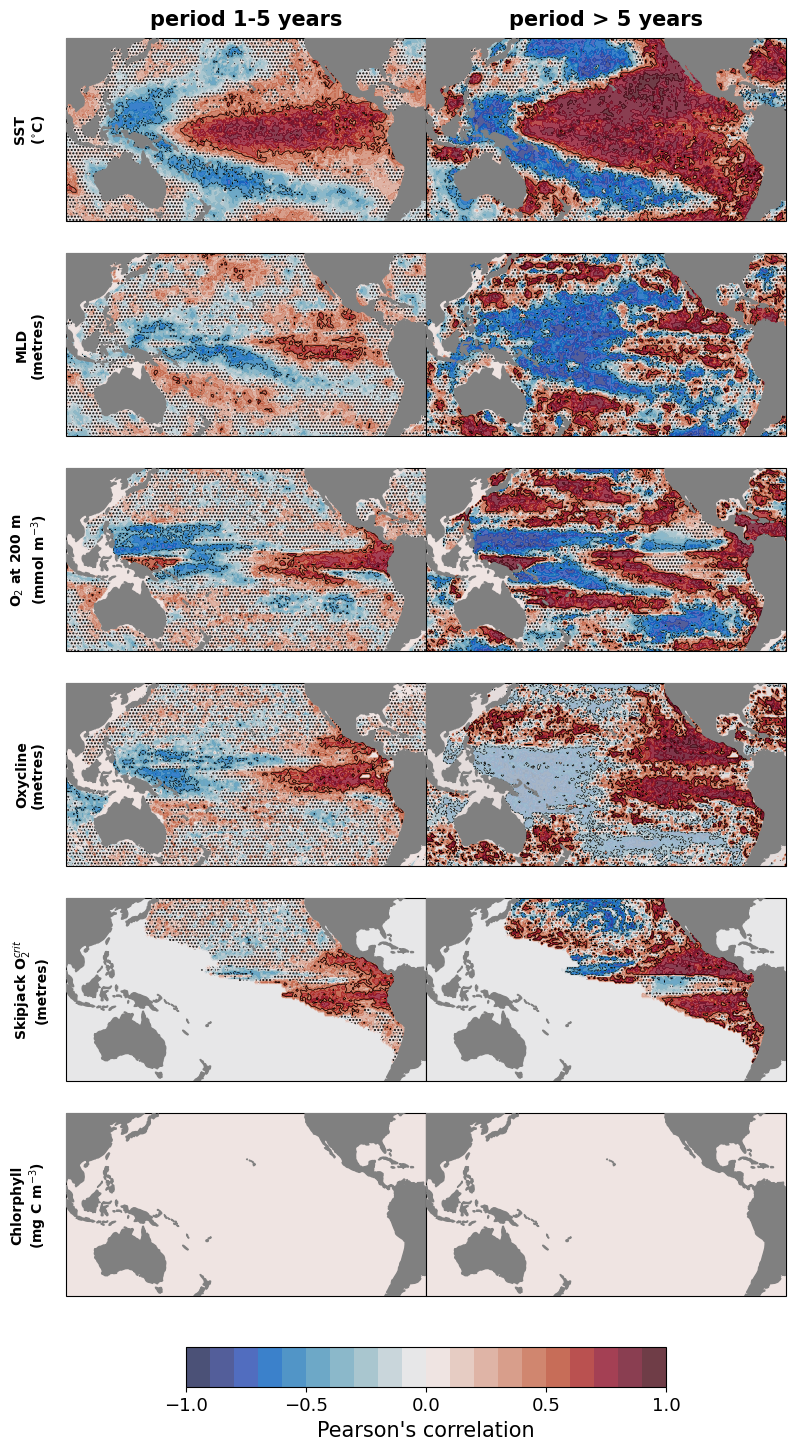

In [56]:

lon_sst = sst_imfs.coords['lon'].values
lat_sst = sst_imfs.coords['lat'].values
lon_oxy = oxy200m_imfs.coords['lon'].values
lat_oxy = oxy200m_imfs.coords['lat'].values
lon_chl = chl_imfs.coords['lon'].values
lat_chl = chl_imfs.coords['lat'].values

fslab = 15
fstic = 13

proj = ccrs.Robinson(central_longitude=205)

colmap = lighten(cmo.balance, 0.8)
levs = np.arange(-1,1.1,0.1)
contlevs = [-0.5, 0.5]
hatching = [' ', '.....']
hatchlevs = [0.0, 0.05, 1.0]

fig = plt.figure(figsize=(8,16))
gs = GridSpec(6, 2)

ax1 = plt.subplot(gs[0,0], projection=proj)
ax2 = plt.subplot(gs[0,1], projection=proj)
ax3 = plt.subplot(gs[1,0], projection=proj)
ax4 = plt.subplot(gs[1,1], projection=proj)
ax5 = plt.subplot(gs[2,0], projection=proj)
ax6 = plt.subplot(gs[2,1], projection=proj)
ax7 = plt.subplot(gs[3,0], projection=proj)
ax8 = plt.subplot(gs[3,1], projection=proj)
ax9 = plt.subplot(gs[4,0], projection=proj)
ax10 = plt.subplot(gs[4,1], projection=proj)
ax11 = plt.subplot(gs[5,0], projection=proj)
ax12 = plt.subplot(gs[5,1], projection=proj)

p1 = ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax1.contour(lon_sst, lat_sst, enso_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax1.contourf(lon_sst, lat_sst, enso_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p2 = ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax2.contour(lon_sst, lat_sst, ipo_sst_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax2.contourf(lon_sst, lat_sst, ipo_sst_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p3 = ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax3.contour(lon_sst, lat_sst, enso_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax3.contourf(lon_sst, lat_sst, enso_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p4 = ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax4.contour(lon_sst, lat_sst, ipo_mld_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax4.contourf(lon_sst, lat_sst, ipo_mld_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p5 = ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax5.contour(lon_oxy, lat_oxy, enso_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax5.contourf(lon_oxy, lat_oxy, enso_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p6 = ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax6.contour(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax6.contourf(lon_oxy, lat_oxy, ipo_oxy200m_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p7 = ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax7.contour(lon_oxy, lat_oxy, enso_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax7.contourf(lon_oxy, lat_oxy, enso_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p8 = ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:]-1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax8.contour(lon_oxy, lat_oxy, ipo_oxycline_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax8.contourf(lon_oxy, lat_oxy, ipo_oxycline_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p9 = ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax9.contour(lon_oxy, lat_oxy, enso_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax9.contourf(lon_oxy, lat_oxy, enso_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p10 = ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:]-1e-3, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax10.contour(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax10.contourf(lon_oxy, lat_oxy, ipo_p50_critz_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p11 = ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax11.contour(lon_chl, lat_chl, enso_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax11.contourf(lon_chl, lat_chl, enso_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

p12 = ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:]+1e-2, cmap=colmap, levels=levs, extend='neither', transform=ccrs.PlateCarree())
ax12.contour(lon_chl, lat_chl, ipo_chl_ccoef[0,:,:], colors='k', linewidths=0.5, levels=contlevs, transform=ccrs.PlateCarree())
ax12.contourf(lon_chl, lat_chl, ipo_chl_ccoef[1,:,:], colors='none', levels=hatchlevs, hatches=hatching, transform=ccrs.PlateCarree())

ax1.add_feature(cfeature.LAND, color='grey', zorder=3)
ax2.add_feature(cfeature.LAND, color='grey', zorder=3)
ax3.add_feature(cfeature.LAND, color='grey', zorder=3)
ax4.add_feature(cfeature.LAND, color='grey', zorder=3)
ax5.add_feature(cfeature.LAND, color='grey', zorder=3)
ax6.add_feature(cfeature.LAND, color='grey', zorder=3)
ax7.add_feature(cfeature.LAND, color='grey', zorder=3)
ax8.add_feature(cfeature.LAND, color='grey', zorder=3)
ax9.add_feature(cfeature.LAND, color='grey', zorder=3)
ax10.add_feature(cfeature.LAND, color='grey', zorder=3)
ax11.add_feature(cfeature.LAND, color='grey', zorder=3)
ax12.add_feature(cfeature.LAND, color='grey', zorder=3)

plt.subplots_adjust(top=0.95, right=0.975, left=0.075, wspace=0.0, hspace=0.05, bottom=0.15)

cbax = fig.add_axes([0.225, 0.1, 0.6, 0.025])
cbar = plt.colorbar(p1, cax=cbax, orientation='horizontal', ticks=levs[::5])
cbar.ax.set_xlabel("Pearson's correlation", fontsize=fslab)
cbar.ax.tick_params(labelsize=fstic)

xx = -0.1; yy = 0.5
plt.text(xx, yy, 'SST\n($^{\circ}$C)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax1.transAxes)
plt.text(xx, yy, 'MLD\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax3.transAxes)
plt.text(xx, yy, 'O$_2$ at 200 m\n(mmol m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax5.transAxes)
plt.text(xx, yy, 'Oxycline\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax7.transAxes)
plt.text(xx, yy, 'Skipjack O$^{crit}_2$\n(metres)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax9.transAxes)
plt.text(xx, yy, 'Chlorphyll\n(mg C m$^{-3}$)', ha='center', va='center', fontsize=fstic-3, fontweight='bold', rotation=90, transform=ax11.transAxes)

ax1.text(0.5, 1.1, 'period 1-5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 1.1, 'period > 5 years', fontsize=fslab, fontweight='bold', ha='center', va='center', transform=ax2.transAxes)

lon1 = 100; lon2 = 300
lat1 = -45; lat2 = 45
ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax2.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax3.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax4.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax5.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax6.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax7.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax8.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax9.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax10.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax11.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax12.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())



In [ ]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific.png", dpi=300)
fig.savefig("./figures/obs_decomposition_correlations_zoompacific_transparent.png", dpi=300, transparent=True)
